### Modelling Process

In [2]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import string
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
stemmer = nltk.stem.PorterStemmer()
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
%matplotlib inline
from scipy import misc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import f1_score

from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [3]:
# load in cleaned data set
df = pd.read_csv('GoC Spend Data Cleaned (Quantity, Unit Price, Total Price, Supplier Name, Item Name, Item Description, UNSPSC Segment).csv', encoding ='utf-8')

In [4]:
# check shape of dataset
df.shape

(326308, 8)

In [5]:
#take a quick peak into the dataset
df.head(5)

,Quantity,Unit Price,Total Price,Supplier Name,Item Name,Item Description,Segment Target,Segment Target Cat
0,1.0,3593.00,3593.00,"A&M Uniforms, Inc.",uniforms,uniforms,Other Goods,24
1,1.0,995.04,995.04,IBHP INCORPORATED,hat,hat,Other Goods,24
2,1.0,2777.60,2777.60,McKesson Medical - Surgical Minnesota Su,adult diapers,adult diapers,Other Goods,24
3,100.0,4.22,422.00,SUCCOR INTERNATIONAL,"Flashlight Pouch, Black",Condor # MA48-002,Other Goods,24
4,60.0,24.00,1440.00,Edwards Medical,Large Pullup Breifs,Large Pullup Breifs - Covidien,Other Goods,24


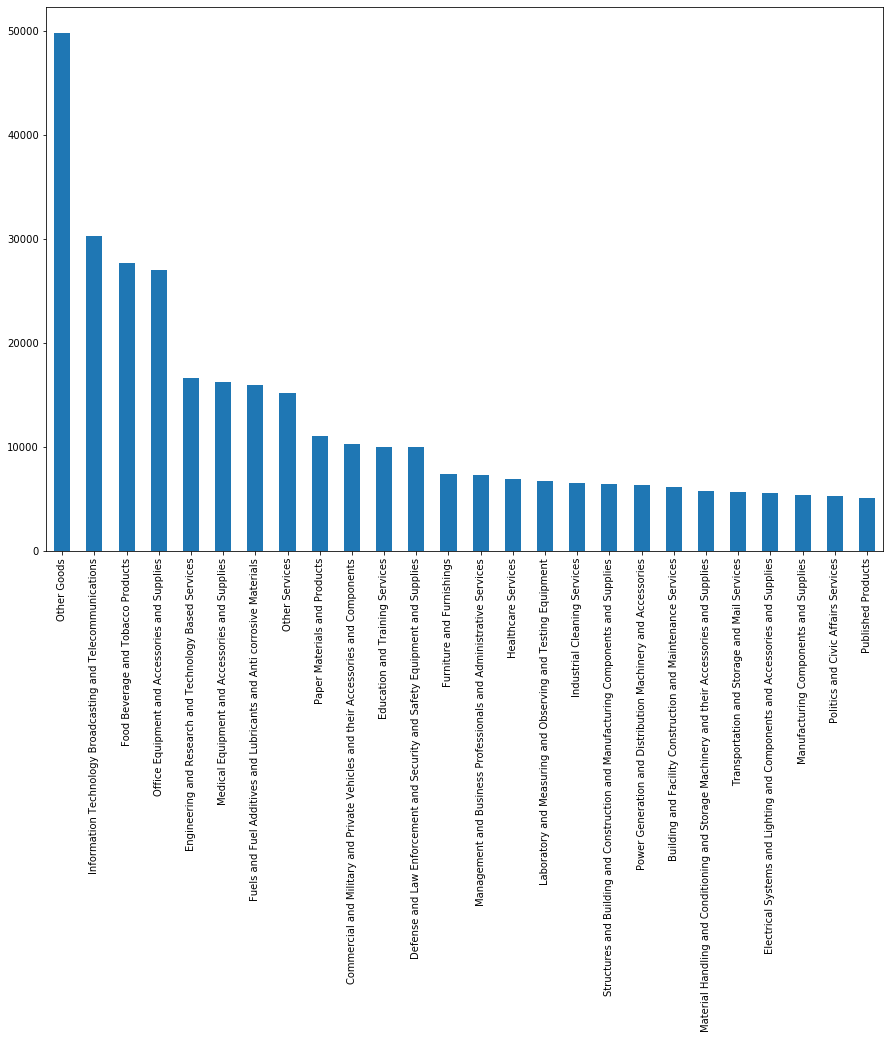

In [6]:
# plot distribution of segments
plt.figure()
df['Segment Target'].value_counts().plot( kind='bar', figsize=(15,10))
plt.show()

### Group Analysis

In [9]:
# stratified train test split with 20% for test set, random state of 13

X = df[['Quantity', 'Unit Price', 'Total Price', 'Supplier Name', 'Item Name', 'Item Description']]
y = df['Segment Target Cat']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13, stratify = y)

plt.figure(figsize=(15,10))
plt.bar(labels=dict_segment.keys(), y_train.value_counts())
plt.xticks(labels=dict_segment.keys())
plt.show()

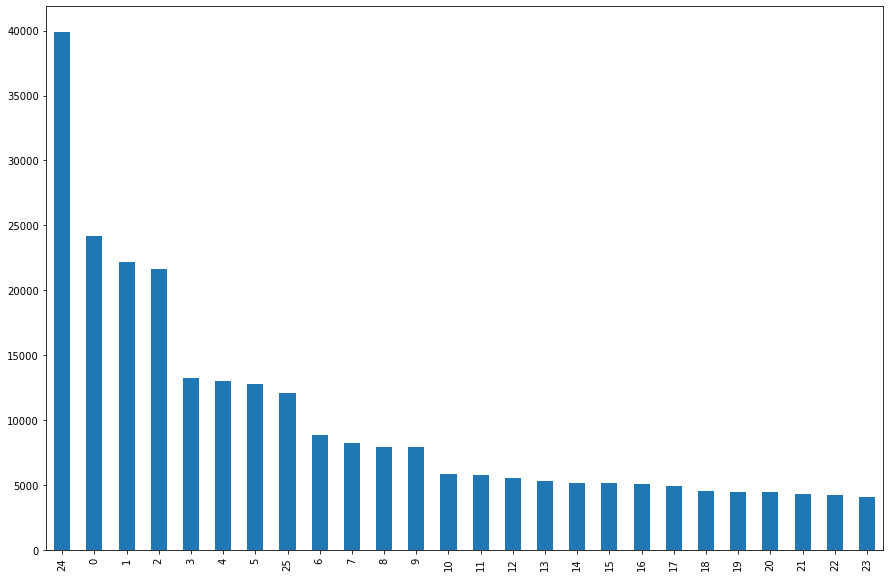

In [10]:

y_train.value_counts().plot( kind='bar', figsize=(15,10))

In [11]:
# Confirm the correct split of the data
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (261046, 6)
y_train shape: (261046,)
X_test shape: (65262, 6)
y_test shape: (65262,)


The below code was taken from BrainStation classnotes

In [12]:
# create a tokenizer function

from nltk.corpus import stopwords 
ENGLISH_STOP_WORDS = stopwords.words('english')

def my_tokenizer(sentence):
    
    for punctuation_mark in string.punctuation:
        # Remove punctuation and set to lower case
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
        
    # Remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

Create a TF-IDF Model for Item Name

In [13]:
# TF-IDF vertorization for Item Name
tfidf_ItemNV = TfidfVectorizer(min_df=10, tokenizer = my_tokenizer, ngram_range = (1,2))
tfidf_ItemNV.fit(X_train['Item Name'])

#Transform both X_train and X_test
X_train_ItemNV = tfidf_ItemNV.transform(X_train['Item Name'])
X_test_ItemNV = tfidf_ItemNV.transform(X_test['Item Name'])

Create a TF-IDF Model for Item Description

In [14]:
# TF-IDF vertorization for Item Description
tfidf_ItemDV = TfidfVectorizer(min_df=25, tokenizer = my_tokenizer, ngram_range = (1,2))
tfidf_ItemDV.fit(X_train['Item Description'])

#Transform both X_train and X_test
X_train_ItemDV = tfidf_ItemDV.transform(X_train['Item Description'])
X_test_ItemDV = tfidf_ItemDV.transform(X_test['Item Description'])

Create a TF-IDF Model for Supplier Name

In [15]:
# TF-IDF vertorization for Supplier Name
tfidf_SNV = TfidfVectorizer(min_df=4, ngram_range = (1,2))
tfidf_SNV.fit(X_train['Supplier Name'])

#Transform both X_train and X_test 
X_train_SNV = tfidf_SNV.transform(X_train['Supplier Name'])
X_test_SNV = tfidf_SNV.transform(X_test['Supplier Name'])

Check to ensure matrices do not have too many features versus number of rows it is over fitting

In [16]:
#check shape of X_train matrices
print('X_train_ItemNV Shape: ', X_train_ItemNV.shape)
print('X_train_ItemDV Shape: ', X_train_ItemDV.shape)
print('X_train_SNV Shape: ', X_train_SNV.shape)

#check shape of X_train matrices
print(X_test_ItemNV.shape)
print(X_test_ItemDV.shape)
print(X_test_SNV.shape)

X_train_ItemNV Shape:  (261046, 13612)
X_train_ItemDV Shape:  (261046, 8828)
X_train_SNV Shape:  (261046, 17191)
(65262, 13612)
(65262, 8828)
(65262, 17191)


In [17]:
from scipy.sparse import hstack

# merge Supplier Name, Item Name and Item Description sparse matrices into X_train_sparse
X_train_sparse = hstack((X_train_SNV, X_train_ItemNV, X_train_ItemDV))

# merge Supplier Name, Item Name and Item Description sparse matrices into X_test_sparse
X_test_sparse = hstack((X_test_SNV, X_test_ItemNV, X_test_ItemDV))

print(X_train_sparse.shape)
print(X_test_sparse.shape)

(261046, 39631)
(65262, 39631)


In [18]:
# instantiate LinearSVC Model
LinearSVC_model = LinearSVC(C=1,multi_class ='ovr', random_state=13)

# fit
LinearSVC_model.fit(X_train_sparse, y_train)

# cross-validation score
LinearSVC_model_cv_score = np.mean(cross_val_score(LinearSVC_model, X_train_sparse, y_train, cv = 3, n_jobs = -1))
print('LinearSVC Cross Validation Score:', round(LinearSVC_model_cv_score,5))

LinearSVC Cross Validation Score: 0.74373


In [19]:
from sklearn.multiclass import OneVsRestClassifier
# instantiate OneVsRestClassifier
LR_OnevsRest_model = OneVsRestClassifier(LogisticRegression( C=1, solver = 'lbfgs', random_state=13, n_jobs =-1), n_jobs=-1)

# fit
LR_OnevsRest_model.fit(X_train_sparse, y_train)

# cross-validation score
LR_OnevsRest_model_cv_score = np.mean(cross_val_score(LR_OnevsRest_model, X_train_sparse, y_train, cv = 3, n_jobs = -1))
print('OnevsRest Logistic Regression Cross Validation Score:', round(LR_OnevsRest_model_cv_score,5))

OnevsRest Logistic Regression Cross Validation Score: 0.74522


In [27]:
from sklearn.ensemble import ExtraTreesClassifier

ETC = ExtraTreesClassifier(n_estimators=20, max_depth=2000, criterion='gini', n_jobs = -1,  random_state=13)

# fit
ETC.fit(X_train_sparse, y_train)

# cross-validation score
ETC_cv_score = np.mean(cross_val_score(ETC, X_train_sparse, y_train, cv = 3, n_jobs = -1))
print('ExtraTrees Cross Validation Score:',round( ETC_cv_score,5))

ExtraTrees Cross Validation Score: 0.73407


As you can se, all of the models show relatively high predictive value on their own. However, when incorperated to a weighted voting ensemble, the cross validation score shows a marginal increase. 

In [ ]:
print('LinearSVC Cross Validation Score:', round(LinearSVC_model_cv_score,5))
print('OnevsRest Logistic Regression Cross Validation Score:', round(LR_OnevsRest_model_cv_score,5))
print('ExtraTrees Cross Validation Score:',round( ETC_cv_score,5))

#### Weighted Soft Voting Ensemble Model

Each of the three above models where optimzied for the hyperparamters using GridSearch. Code not included in this workbook. 

Below is the loop ran to optimize voting weights. It is not run in the notebook as it is very computationally heavy. The results showed the following weights to have the highest cross validation score.  
  
LinearSVC (0.5) - the model incorperated CalibratedClassifierCV using a sigmoid methode to allow for probabilities  
OneVsRestClassificier(LogisiticRegression) (4)  
EtraTreesClassifier (3)  



In [ ]:
# instatiate voting ensemble models
LinearSVC_model_p = CalibratedClassifierCV(LinearSVC(C=1,multi_class ='ovr', random_state=13), method='sigmoid', cv=3)
LR_OnevsRest_model =  OneVsRestClassifier(LogisticRegression( C=1, solver = 'lbfgs', random_state=13, n_jobs =-1), n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=20, max_depth=2000, criterion='gini', n_jobs = -1,  random_state=13)

#set up variables for the for loops
voting_weights = [0.5,1,1.5,2,3,4]
count = 0

# create the for loops
for a in voting_weightsa:
    for b in voting_weights:
        for c in voting_weights:
            
            #build the ensemble model
            voting_ensemble_loop = VotingClassifier(estimators=[('LinearSVC_model_p', LinearSVC_model_p),\
                                            ('LR_OnevsALL_model', LR_OnevsRest_model),
                                            ('ETC', ETC)],\
                                            voting="soft",\
                                            weights = [a,b,c], n_jobs=-1)

            # fit ensemble model
            voting_ensemble_loop.fit(X_train_sparse, y_train)
            
            # cross validation model accuracy 
            voting_ensemble_loop_cv_score = np.mean(cross_val_score(voting_ensemble_loop, X_train_sparse, y_train, cv = 3, n_jobs = -1))
            
            # number of the loop
            count += 1
            
            # print results
            print('For Loop Count, LinearSVC weight, OnevsRest Logistic Regression weight, ExtraTrees weight, Training Cross Validation Score: ', count, a, b, c, round(voting_ensemble_loop_cv_score,5))

#### Final model

**The final weighted soft voting ensemble model predicted the test data with a 77% accuracy**

In [21]:
# instatiate voting ensemble models
LinearSVC_model_p = CalibratedClassifierCV(LinearSVC(C=1,multi_class ='ovr', random_state=13), method='sigmoid', cv=3)
LR_OnevsRest_model =  OneVsRestClassifier(LogisticRegression( C=1, solver = 'lbfgs', random_state=13, n_jobs =-1), n_jobs=-1)
ETC = ExtraTreesClassifier(n_estimators=20, max_depth=2000, criterion='gini', n_jobs = -1,  random_state=13)

# build the ensemble model        
voting_ensemble_final = VotingClassifier(estimators=[('LinearSVC_model_p ', LinearSVC_model_p),\
                                            ('LR_OnevsALL_model', LR_OnevsRest_model),\
                                            ('ETC', ETC)],\
                                            voting="soft",\
                                            weights = [0.5,4,3], n_jobs=-1)

# fit ensemble model
voting_ensemble_final.fit(X_train_sparse, y_train)

# cross validation model accuracy 
cv_score = np.mean(cross_val_score(voting_ensemble_final, X_train_sparse, y_train, cv = 3, n_jobs = -1))

# test accuracy 
acc_score_test = voting_ensemble_final.score(X_test_sparse, y_test)

# print results
print('Train accuracy score: ', round(cv_score,5))
print('Test accuracy score: ', round(acc_score_test,5))

Train accuracy score:  0.76081
Test accuracy score:  0.77056


### Preliminary look at results

Create a dictionary to map segment target numeric categories back to their string names

In [7]:
df_segment = df[['Segment Target Cat', 'Segment Target']].drop_duplicates()
df_segment

,Segment Target Cat,Segment Target
0,24,Other Goods
5964,17,Building and Facility Construction and Mainten...
18687,7,Commercial and Military and Private Vehicles a...
29001,9,Defense and Law Enforcement and Security and S...
48371,25,Other Services
50666,8,Education and Training Services
60625,20,Electrical Systems and Lighting and Components...
68073,3,Engineering and Research and Technology Based ...
89268,1,Food Beverage and Tobacco Products
116950,5,Fuels and Fuel Additives and Lubricants and An...


In [186]:
# create a dictionary 
dict_segment = pd.Series(df['Segment Target'].values,index=df['Segment Target Cat']).to_dict()

In [199]:
# create df fpr categories names based on category number
cat_num = df['Segment Target Cat'].unique()
cat_num = pd.DataFrame(sorted(cat_num), columns=['Segment Target Cat'])
sorted_cat_names = cat_num['Segment Target Cat'].map(dict_segment)

#### Statistical Results

While it be better to have ROC Curve graphs for each category, due to the high computation nature of the final voting ensemble and deliverable timeline, for the sake of this report it was not conducted. However below shows the classification report graphically. Insipration taken from [here](https://stackoverflow.com/questions/38609339/pandas-dataframe-to-seaborn-grouped-barchart/38611976). Below is the vanilla classification report showing that precision and recall is all over the place depending on which category examined. However, for the most part the f1-scores were decently high.

In [201]:
y_pred_test_voting_ensemble_final = voting_ensemble_final.predict(X_test_sparse)
print(classification_report(y_test,y_pred_test_voting_ensemble_final, target_names= sorted_cat_names))

                                                                                             precision    recall  f1-score   support

                                 Information Technology Broadcasting and Telecommunications       0.76      0.82      0.79      6055
                                                         Food Beverage and Tobacco Products       0.91      0.98      0.94      5536
                                              Office Equipment and Accessories and Supplies       0.79      0.91      0.84      5401
                                     Engineering and Research and Technology Based Services       0.73      0.75      0.74      3318
                                             Medical Equipment and Accessories and Supplies       0.74      0.80      0.77      3246
                       Fuels and Fuel Additives and Lubricants and Anti corrosive Materials       0.86      0.96      0.91      3198
                                                               Paper

In [188]:
# get y_predicted
y_pred_test_voting_ensemble_final = voting_ensemble_final.predict(X_test_sparse)

# create a classification report dataframe
df_test_classification = pd.DataFrame(classification_report(y_test,y_pred_test_voting_ensemble_final, target_names= sorted_cat_names, output_dict=True)).T.reset_index()

# correctly label rows
df_test_classification.columns = ['Segment', 'Precision Score', 'Recall Score', 'F1-Score', 'Item Lines']
# drop number of item lines
df_test_classification = df_test_classification[['Segment', 'Precision Score', 'Recall Score', 'F1-Score']]

# create new dataframe in format needed for seaborn
df_test_classification_graph = pd.melt(df_test_classification, id_vars=['Segment']).sort_values(['variable','value'])

Graphical representation of the test results classification report

[]

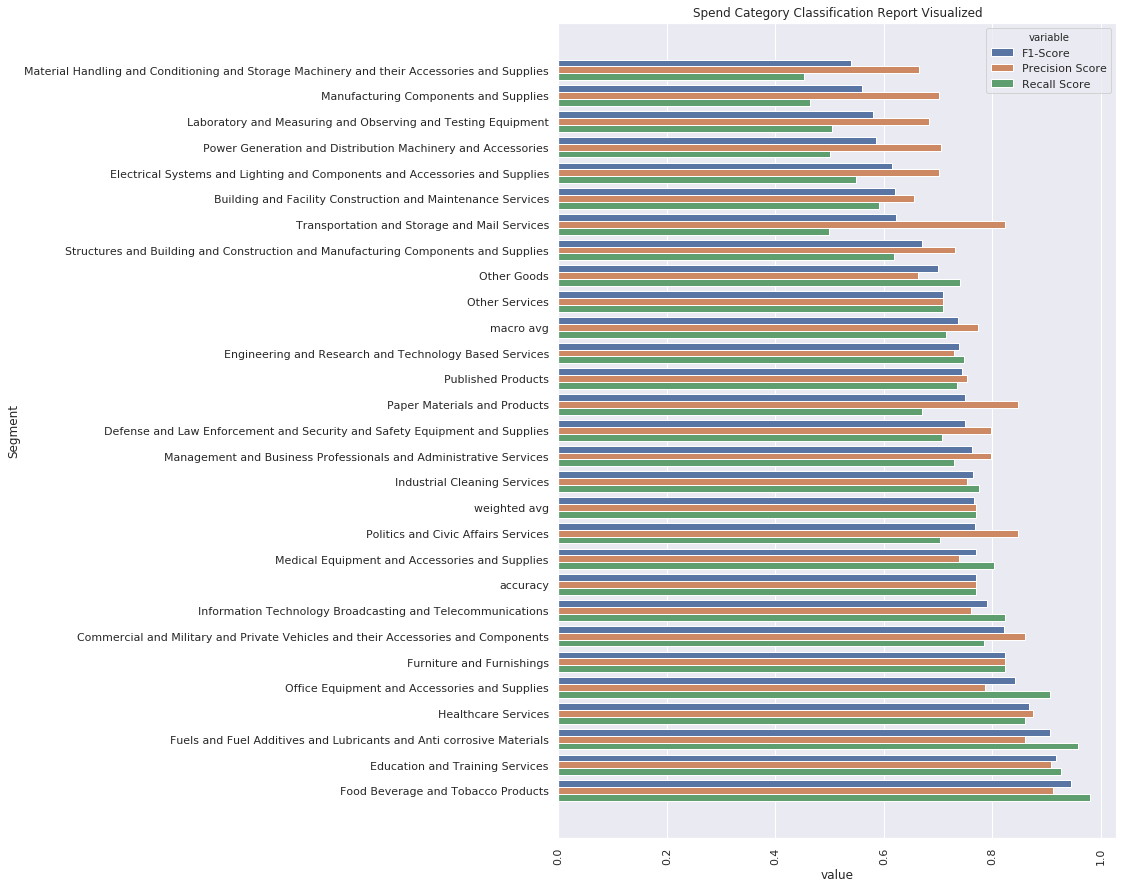

In [198]:
#plot grouped bar chart
plt.figure(figsize=(10,15))
sns.barplot(x='value', y='Segment', hue='variable', data=df_test_classification_graph)
plt.xticks(rotation=90)
plt.title('Spend Category Classification Report Visualized')
plt.plot()

#### Confusion Matrix

The original categories showed marginal confusion between themselves, aside from a few intances - for example Transportation Services and Fuels & Lubbricates. This is to be expected when using free text columns as features as employees may have not spend much effort differentiating item purchased and delivery method. However, the 2 catch all categories of Other Services and Other Services shows consistent misclassification across the majority of the categories and vice versa. This seems to be a consequence of having a broad range of infrequent commodities placed into two synthetic categories, creating confusion for the model.  

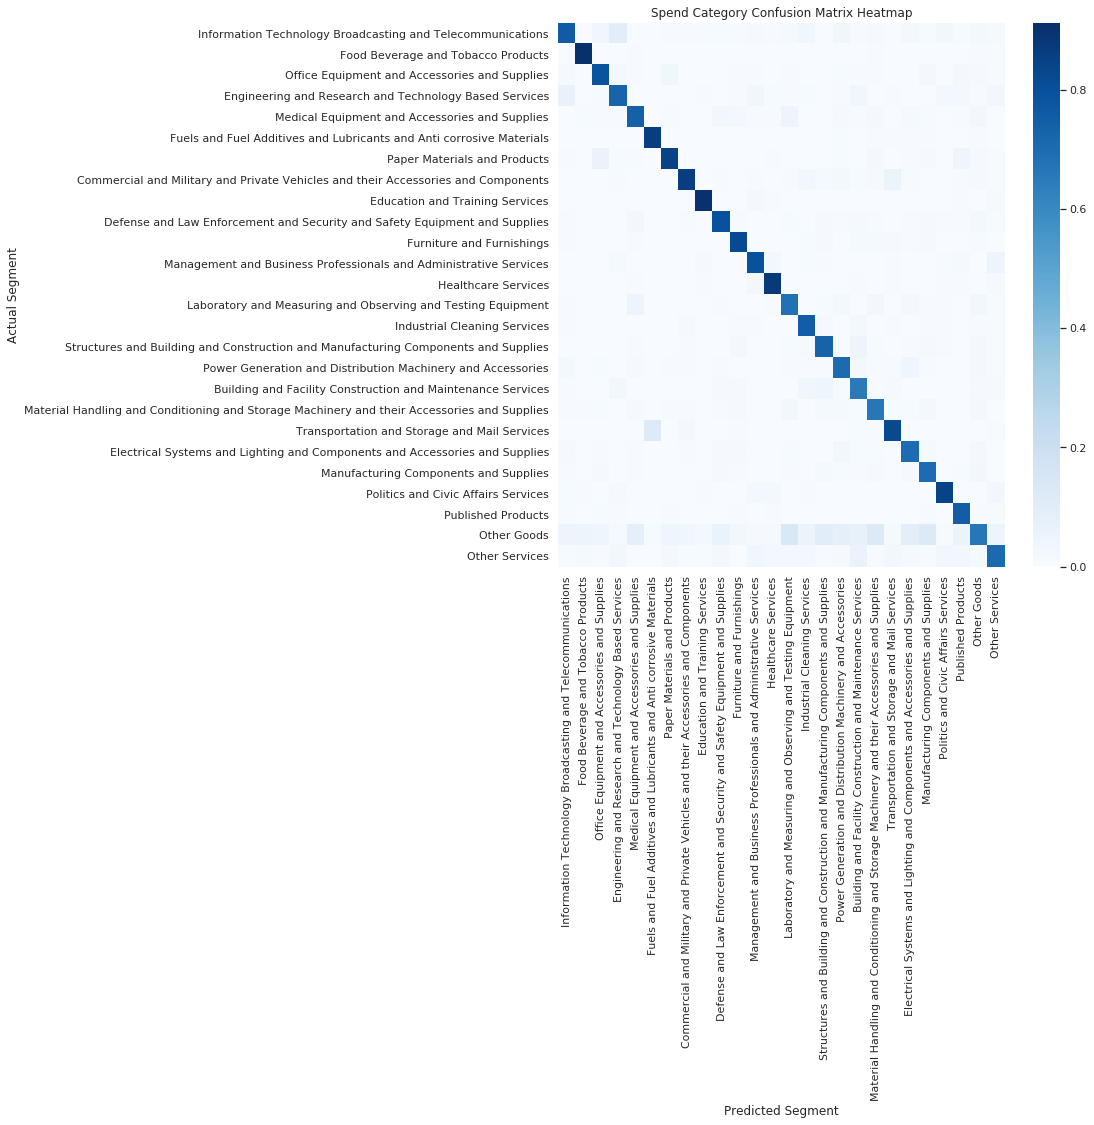

In [115]:
# create confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_test_voting_ensemble_final, normalize='pred')

# fig size
plt.figure(figsize=(10,10))

# heatmap
sns.heatmap(conf_mat, xticklabels=sorted_cat_names, cmap="Blues", yticklabels=sorted_cat_names)

# labels 
plt.title('Spend Category Confusion Matrix Heatmap')
plt.ylabel('Actual Segment')
plt.xlabel('Predicted Segment')

# show
plt.show()

#### Further exploration of results an be found in the Results notebook.

Set up dataframe to be exported

In [48]:
cat_num = df['Segment Target Cat'].unique()
cat_num = pd.DataFrame(sorted(cat_num), columns=['Segment Target Cat'])
sorted_cat_names = cat_num['Segment Target Cat'].map(dict_segment)

In [23]:
# create a dataframe with Quantity, Unit Price and Total Price from the test set
X_test_results = X_test[['Quantity', 'Unit Price', 'Total Price']].copy()

# Add a column with the actual test category numbers
X_test_results['Segment Actual'] = y_test
# map test category names to the actual test category numbers
X_test_results['Segment Actual'] = X_test_results['Segment Actual'].map(dict_segment)

# add a column with the predicted test category numbers
X_test_results['Segment Predicted'] = y_pred_test_voting_ensemble_final
# map test category names to the predicted test category numbers
X_test_results['Segment Predicted'] = X_test_results['Segment Predicted'].map(dict_segment)

In [24]:
# create a column 
X_test_results['Predicted Correctly'] = np.where(X_test_results['Segment Actual'] == X_test_results['Segment Predicted'], 1, 0)

In [25]:
# check if mean of correctly predicted and test accuracy score match
print('Mean of correctly predicted: ', round(X_test_results['Predicted Correctly'].mean(), 5))
print('Test accuracy score: ', round(acc_score_test,5))

Mean of correctly predicted:  0.77056
Test accuracy score:  0.77056


In [26]:
# export dataframe to a csv
X_test_results.to_csv('GoC Spend Data TF-IDF Model Results.csv', index=False)